In [1]:
!pip install scikit-learn==1.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 30.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/train.csv")
df_prep = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df_prep

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


In [6]:
def prepare_num(df):
    df_num = df.drop(['Sex', 'Embarked', 'Pclass'], axis=1)
    df_sex = pd.get_dummies(df['Sex'])
    df_emb = pd.get_dummies(df['Embarked'], prefix='Emb')
    df_pcl = pd.get_dummies(df['Pclass'], prefix='Pclass')

    df_num = pd.concat((df_num, df_sex, df_emb, df_pcl), axis=1)
    return df_num

In [7]:
df_prep_num = prepare_num(df_prep)
df_prep_num = df_prep_num.fillna(df_prep_num.median())
scaler = MinMaxScaler()
df_prep_num

,Survived,Age,SibSp,Parch,Fare,female,male,Emb_C,Emb_Q,Emb_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,0,1,0,0,1,0,1,0
887,1,19.0,0,0,30.0000,1,0,0,0,1,1,0,0
888,0,28.0,1,2,23.4500,1,0,0,0,1,0,0,1
889,1,26.0,0,0,30.0000,0,1,1,0,0,1,0,0


In [8]:
# отдаем 60% на train, 20% на validate,20% на test
train, validate, test = np.split(df_prep_num.sample(frac=1, random_state=10),
                                 [int(.7 * len(df_prep_num)), int(.8 * len(df_prep_num))])
train_x = train.drop('Survived', axis=1)
train_y = train

validate_x = validate.drop('Survived', axis=1)
validate_y = validate

test_x = test.drop('Survived', axis=1)
test_y = test

In [9]:
# подбор гиперпараметров для RandomForest

crit = ("gini", "entropy")
acc_0 = 0
cr_0 = " "
est_0 = 0
dep = 0
for cr in crit:
    for estimators in range(10, 51):
        for depth in range(1, 11):
            model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, criterion=cr)
            model.fit(train_x, train_y['Survived'])
            predict = model.predict(validate_x)
            acc = accuracy_score(validate_y['Survived'], predict)
            if acc_0 < acc:
                acc_0 = acc
                cr_0 = cr
                est_0 = estimators
                dep = depth

print("RandomForest")
print("criterion: ",cr_0)
print("n_estimators: ",est_0)
print("max_depth: ",dep)
print("accuracy validation: ",acc_0)

RandomForest
criterion:  gini
n_estimators:  16
max_depth:  9
accuracy validation:  0.9101123595505618


In [10]:
model = RandomForestClassifier(n_estimators=est_0, max_depth=dep, criterion=cr_0)
model.fit(train_x, train_y['Survived'])
predict = model.predict(test_x)
acc = accuracy_score(test_y['Survived'], predict)

In [11]:
print("accuracy test: ",acc)
print(acc)


accuracy test:  0.8435754189944135
0.8435754189944135


2.С помощью RandomForest выберите 2, 4, 8 самых важных признаков и проверьте точность моделей только на этих признаках.

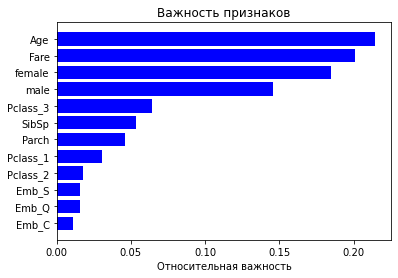

In [12]:
df_prep_num_s = df_prep_num.drop("Survived",axis=1)
model = RandomForestClassifier(n_estimators=est_0, max_depth=dep, criterion=cr_0)
model.fit(train_x, train_y['Survived'])
importances = model.feature_importances_
features = df_prep_num_s.columns
# Добавление сортировки по важности
indices = np.argsort(importances)

plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Относительная важность')
plt.show()



In [13]:
def n_important_signs(n):
  important_2 = df_prep_num[features[indices][-n:]]
  train_f2, validate_f2, test_f2 = np.split(important_2.sample(frac=1, random_state=10),
                                 [int(.7 * len(important_2)), int(.8 * len(important_2))])
# df_prep_num_su =df_prep_num[features[indices][::-3][:2]] 
  train_fx = train_f2
  train_fy = train_y['Survived']

  validate_fx = validate_f2
  validate_fy = validate_y['Survived']

  test_fx = test_f2
  test_fy = test_y['Survived']

# scl_important_2 = scaler.fit_transform(important_2)
  model.fit(train_fx,train_fy)
  predict = model.predict(test_f2)
  acc = accuracy_score(test_fy, predict)
  return acc
  # print("Accuracy: {:.2%}".format(acc))


Точность модели по двум важным признакам

In [14]:
acc = n_important_signs(2)
print("Accuracy: {:.2%}".format(acc))

Accuracy: 67.04%


Точность модели по четырем важным признакам

In [15]:
acc = n_important_signs(4)
print("Accuracy: {:.2%}".format(acc))

Accuracy: 82.12%


Точность модели по восьми важным признакам

In [16]:
acc = n_important_signs(8)
print("Accuracy: {:.2%}".format(acc))

Accuracy: 84.92%


In [17]:
# подбор гиперпараметров для XGBoost
acc_0 = 0
est_0 = 0
dep = 0
for estimators in range(1,20):
  for depth in range(1,10):
    model = XGBClassifier(n_estimators=estimators, max_depth=depth)
    model.fit(train_x, train_y['Survived'])
    predict = model.predict(validate_x)
    acc = accuracy_score(validate_y['Survived'], predict)
    if acc_0 < acc:
      acc_0 = acc
      est_0 = estimators
      dep = depth

print("XGBoost")
print("n_estimators: ",est_0)
print("max_depth: ",dep)
print("accuracy validation: ",acc_0)

XGBoost
n_estimators:  11
max_depth:  5
accuracy validation:  0.8876404494382022


In [18]:
model = XGBClassifier(n_estimators=estimators, max_depth=depth)
model.fit(train_x, train_y['Survived'])
predict = model.predict(test_x)
acc = accuracy_score(test_y['Survived'], predict)
print("accuracy test: ",acc)
print()

accuracy test:  0.8379888268156425



In [19]:
# подбор гиперпараметров для LogisticRegression
solv = ("lbfgs", "liblinear", "newton-cg", "sag", "saga")
сс = [x/100 for x in range(10, 101, 1)]
c_0 = 0
sol_0 = " "
for c in сс:
  for sol in solv:
    model = LogisticRegression(C=c, solver=sol)
    model.fit(train_x, train_y['Survived'])
    predict = model.predict(validate_x)
    acc = accuracy_score(validate_y['Survived'], predict)
    if acc_0 < acc:
      sol_0 = sol
      c_0 = c

print("LogisticRegression")
print("c: ",c_0)
print("solver: ",sol_0)
print("accuracy validation: ",acc_0)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: T

LogisticRegression
c:  0
solver:   
accuracy validation:  0.8876404494382022


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ di

In [20]:
model = LogisticRegression(C=c, solver=sol)
model.fit(train_x, train_y['Survived'])
predict = model.predict(test_x)
acc = accuracy_score(test_y['Survived'], predict)

print("accuracy test: ",acc)
print()

accuracy test:  0.6312849162011173



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# метод ближайших соседей
# alg = ("auto", "ball_tree", "kd_tree", "brute")
# alg_0 = " "
# neib_0 = 0
# leaf_0 = 0
# acc_0 = 0
# for neib in range(1,20):
#   for algo in alg:
#     for leaf in range(1,50):

model = KNeighborsClassifier()
model.fit(train_x, train_y['Survived'])
predict = model.predict(validate_x)
acc = accuracy_score(validate_y['Survived'], predict)
      # if acc_0 < acc:
      #   acc_0 = acc
      #   neib_0 = neib
      #   alg_0 = algo
      #   leaf_0 = leaf

# print(alg_0)
# print(neib_0)
# print(leaf_0)
print("KNN")
print("accuracy validation: ",acc)

KNN
accuracy validation:  0.7303370786516854


In [22]:
model = KNeighborsClassifier()
model.fit(train_x, train_y['Survived'])
predict = model.predict(test_x)
acc = accuracy_score(test_y['Survived'], predict)


print("accuracy validation: ",acc)

accuracy validation:  0.6815642458100558


3.Используя координаты скважин из файла wells_info.csv разделите их на кластера с помощью любых 4 методов и отобразите разделение. Параметры подбираются самостоятельно.

In [23]:
from sklearn.cluster import SpectralClustering,Birch,MeanShift,KMeans
wells_info = pd.read_csv("/content/wells_info.csv")
coordinates = np.array(wells_info[["BottomHoleLatitude", "BottomHoleLongitude"]])

def showClusters(model, data):
    clusters = model.fit_predict(data)
    for cl in clusters:
        _data = data[clusters==cl]
        plt.scatter(_data[:, 0], _data[:, 1])
    plt.show()

SpectralClustering

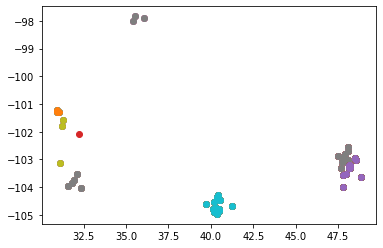

In [24]:
model = SpectralClustering()
showClusters(model,coordinates)

Birch

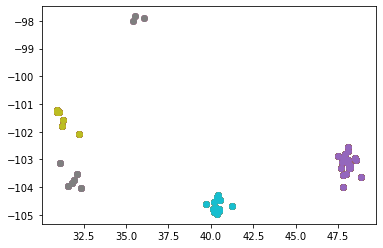

In [25]:
model = Birch(n_clusters=5, threshold=0.7)
showClusters(model,coordinates)

Meanshift

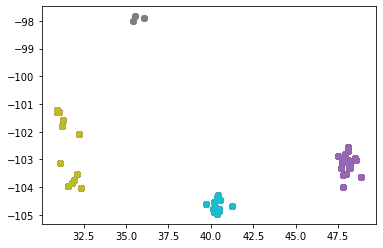

In [26]:
model = MeanShift()
showClusters(model, coordinates)

KMean

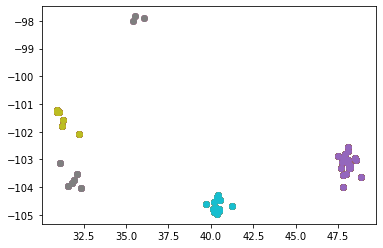

In [27]:
model = KMeans(n_clusters=5, n_init='auto')
showClusters(model, coordinates)

4.Приведите отобранные в 6.1 задании признаки из файла wells_info_with_prod.csv в двумерное пространство. Выделите цветом добычу с этой скважины.

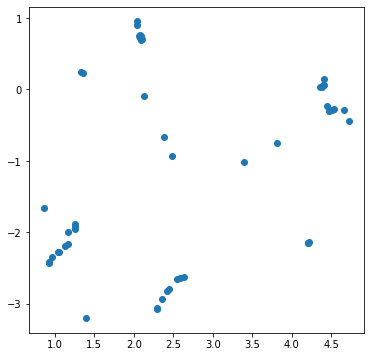

In [28]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

wells_p = pd.read_csv("/content/wells_info_with_prod.csv")
selected_wells = wells_p[["Prod1Year"]]
wells_p.CompletionDate = pd.to_datetime(wells_p.CompletionDate)
wells_date = wells_p.CompletionDate.dt.dayofyear
selected_wells = pd.concat((wells_date,selected_wells, pd.get_dummies(wells_p.formation), pd.get_dummies(wells_p.StateName)), axis=1)
scaled_wells = MinMaxScaler().fit_transform(selected_wells)



model = TSNE(n_components=2)
data = model.fit_transform(scaled_wells)

plt.figure(figsize=(6,6))
plt.scatter(data[:, 0], data[:, 1], marker='o')
plt.show()